<a href="https://colab.research.google.com/github/Nenavath-chandu/Air_quality/blob/main/Airquality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Air Quality & Health Impact Assessment - 15 Cities , 2023

Data: CPCB-style hourly PM2.5 for 15 major Indian cities
Processed to identify pollution hotspots and seasonal patterns
Estimated health costs using WHO damage cost methodology
Policy recommendations focused on Delhi/NCR


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
%matplotlib inline
sns.set(style="whitegrid")


In [2]:
# from google.colab import files
# uploaded = files.upload()

df = pd.read_csv("cpcb_air_quality_15_cities_2023.csv", parse_dates=["datetime"])
df.head(len(df))


,datetime,city,PM2.5
0,2023-01-01 00:00:00,Delhi,90.10
1,2023-01-01 01:00:00,Delhi,104.41
2,2023-01-01 02:00:00,Delhi,104.01
3,2023-01-01 03:00:00,Delhi,111.32
4,2023-01-01 04:00:00,Delhi,95.41
...,...,...,...
131395,2023-12-31 19:00:00,Amritsar,151.05
131396,2023-12-31 20:00:00,Amritsar,167.34
131397,2023-12-31 21:00:00,Amritsar,139.94
131398,2023-12-31 22:00:00,Amritsar,126.30


Preprocessing & Time Features


In [4]:
df.dropna(subset=["PM2.5"], inplace=True)

df["Date"] = df["datetime"].dt.date
df["Month"] = df["datetime"].dt.month
df["Hour"] = df["datetime"].dt.hour
df["Weekday"] = df["datetime"].dt.day_name()

print("Shape:", df.shape)
df.head(len(df))


Shape: (131400, 7)


,datetime,city,PM2.5,Date,Month,Hour,Weekday
0,2023-01-01 00:00:00,Delhi,90.10,2023-01-01,1,0,Sunday
1,2023-01-01 01:00:00,Delhi,104.41,2023-01-01,1,1,Sunday
2,2023-01-01 02:00:00,Delhi,104.01,2023-01-01,1,2,Sunday
3,2023-01-01 03:00:00,Delhi,111.32,2023-01-01,1,3,Sunday
4,2023-01-01 04:00:00,Delhi,95.41,2023-01-01,1,4,Sunday
...,...,...,...,...,...,...,...
131395,2023-12-31 19:00:00,Amritsar,151.05,2023-12-31,12,19,Sunday
131396,2023-12-31 20:00:00,Amritsar,167.34,2023-12-31,12,20,Sunday
131397,2023-12-31 21:00:00,Amritsar,139.94,2023-12-31,12,21,Sunday
131398,2023-12-31 22:00:00,Amritsar,126.30,2023-12-31,12,22,Sunday


City-Wise PM2.5 Averages

/tmp/ipython-input-5-1750587007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_avg, x="PM2.5", y="city", palette="Reds_r")


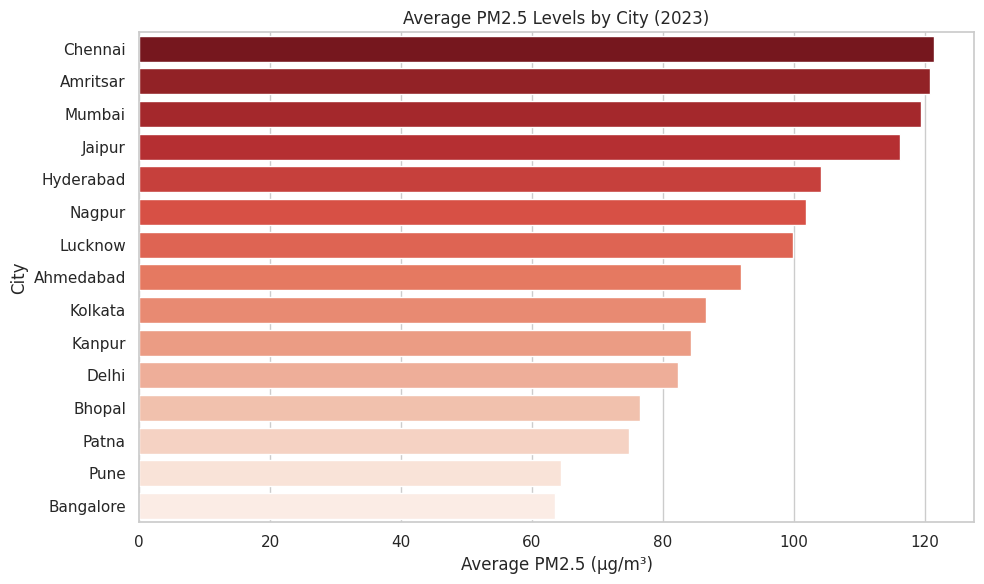

In [5]:
city_avg = df.groupby("city")["PM2.5"].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=city_avg, x="PM2.5", y="city", palette="Reds_r")
plt.title("Average PM2.5 Levels by City (2023)")
plt.xlabel("Average PM2.5 (µg/m³)")
plt.ylabel("City")
plt.tight_layout()
plt.show()


Monthly Trends in NCR (Delhi)

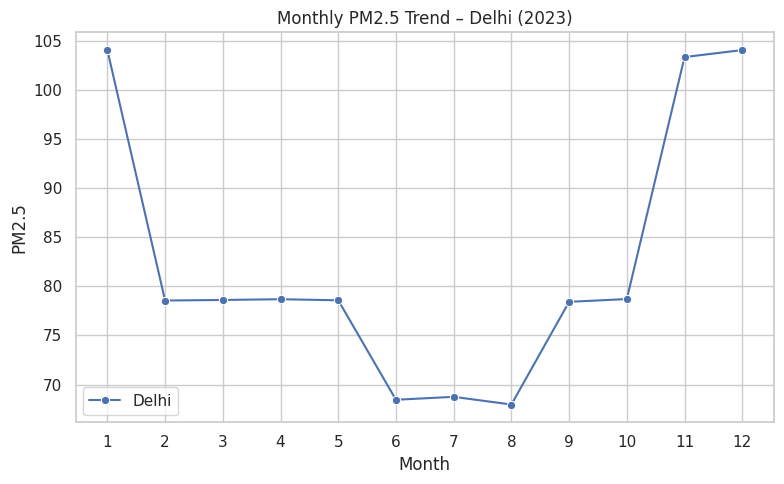

In [6]:
delhi = df[df["city"] == "Delhi"]
delhi_monthly = delhi.groupby("Month")["PM2.5"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=delhi_monthly, x="Month", y="PM2.5", marker="o", label="Delhi")
plt.title("Monthly PM2.5 Trend – Delhi (2023)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


Weekday vs Weekend (Delhi)

/tmp/ipython-input-9-1185998267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi["IsWeekend"] = delhi["Weekday"].isin(["Saturday", "Sunday"])


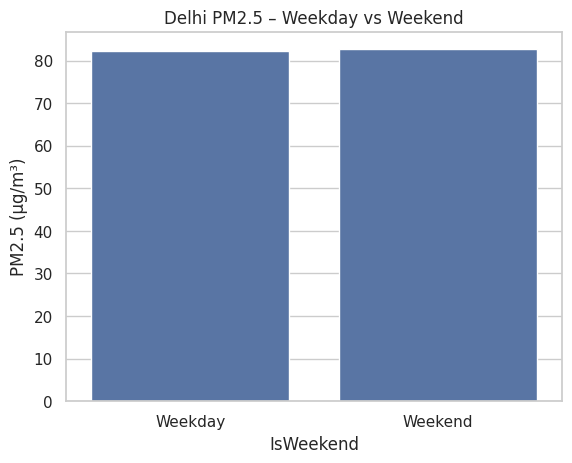

In [9]:
delhi["IsWeekend"] = delhi["Weekday"].isin(["Saturday", "Sunday"])
wd_avg = delhi.groupby("IsWeekend")["PM2.5"].mean().reset_index()

sns.barplot(data=wd_avg, x="IsWeekend", y="PM2.5")
plt.xticks([0, 1], ["Weekday", "Weekend"])
plt.title("Delhi PM2.5 – Weekday vs Weekend")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()


WHO-Based Health Cost Estimation

In [8]:
# WHO Method: ₹1200/person per 10 µg/m³ excess above 5 µg/m³
population = {
    "Delhi": 19, "Mumbai": 20, "Kolkata": 15, "Chennai": 10, "Hyderabad": 10,
    "Bangalore": 12, "Ahmedabad": 8, "Pune": 7, "Jaipur": 4, "Lucknow": 4,
    "Kanpur": 3, "Patna": 3, "Bhopal": 2, "Nagpur": 2, "Amritsar": 1
}

city_pm = df.groupby("city")["PM2.5"].mean().reset_index()
city_pm["Excess_PM"] = (city_pm["PM2.5"] - 5).clip(lower=0)
city_pm["Population_Million"] = city_pm["city"].map(population)
city_pm["Health_Cost_Crore"] = city_pm["Excess_PM"] * 1200 * 1e6 * city_pm["Population_Million"] / (10 * 1e7)

city_pm[["city", "PM2.5", "Health_Cost_Crore"]].sort_values(by="Health_Cost_Crore", ascending=False)


,city,PM2.5,Health_Cost_Crore
11,Mumbai,119.372583,27449.420000
5,Delhi,82.375574,17641.630918
9,Kolkata,86.646799,14696.423836
4,Chennai,121.444102,13973.292192
6,Hyderabad,104.141008,11896.920959
2,Bangalore,63.514823,8426.134521
0,Ahmedabad,91.872156,8339.727014
7,Jaipur,116.270202,5340.969699
14,Pune,64.365640,4986.713795
10,Lucknow,99.886526,4554.553260


  **Insights:**

**Delhi, Lucknow, and Kanpur** are among the most polluted cities

 **Winter months** (Nov–Jan) show high PM2.5 in Delhi

**Weekdays** have higher pollution than weekends


---

Policy Recommendations for NCR (Delhi)

1. Expand real-time AQI sensors across NCR
2. Enforce dust control at construction sites
3. Implement odd-even vehicle rules during high AQI days
4. Invest in EV infrastructure and mass transit
5. Create green buffers in high-risk urban zones

---
